![](https://cdn.mobilesyrup.com/wp-content/uploads/2022/01/wordle.png)

#  Wordle - An Analysis of the Internet's New Favorite Game

[Wordle](https://www.nytimes.com/games/wordle/index.html) has taken the internet by storm. What started off as a fun project to keep one entertained during the pandemic has quickly skyrocketed into a major addiction for many people. This simple word-based guessing game in which you get six chances to guess the right five-letter word has got everyone thinking about the "correct" or "optimized" strategy for success. There have been countless in-depth studies on the game already, alot of which were heavily inspired by 3Blue1Brown's amazing [Youtube](https://www.youtube.com/watch?v=v68zYyaEmEA) [videos](https://www.youtube.com/watch?v=fRed0Xmc2Wg) on the topic where he discusses how he used [Information Theory](https://en.wikipedia.org/wiki/Information_theory#:~:text=Information%20theory%20is%20the%20scientific,Claude%20Shannon%20in%20the%201940s) to help figure out the best opening guess. I was certainly inspired by that video, as well as [several](https://markmliu.medium.com/what-in-the-wordle-5dc5ed94fe2) [other](https://towardsdatascience.com/optimal-wordle-d8c2f2805704) [analyses](https://www.r-bloggers.com/2022/02/wordle-data-analysis/) [I](https://withoutbullshit.com/blog/wordle-revised-mathematical-analysis-of-the-first-guess) came across.

I decided to try to make my on analysis - both out of curiosity and a need for practicing data analysis skills. It was also quite helpful to have so many other anaylses available so that I could cross-reference my results and see if I was getting similar answers. Instead of trying to build a program that will simulate thousands of games (and thus remove *some* of the fun from the game), I have decided to do a more simple analysis on the words used in the game.

## Project Goals

My goals for this project include the following:

* Create a way to automatically scrape the Wordle website and extract the word lists
* Create aesthetically pleasing visualizations for things such as frequency or distribution of letters, etc.
* Explore any possible correlation between individual letters and their positioning in the target word
* Find the most common first letter, as well as the most common follow-up letter

# Import Libraries & Tools

In [1]:
import requests
import math
import re
import os
from os.path import exists
from tqdm import tqdm
from scipy.stats import entropy
from itertools import product
from bs4 import BeautifulSoup
from matplotlib import gridspec

# Constants & Important Variables

In [2]:
#get path to project directory
DATA_DIR = os.path.join(
    os.path.dirname(os.path.realpath("__file__"))
)

#important files & variables
PATTERN_MATRIX_FILE = os.path.join(DATA_DIR, "pattern_matrix.csv")
WORD_FREQ_MAP_FILE = os.path.join(DATA_DIR, "freq_map.json")

#243 combinations of colors (3^5) - g = green, r = gray, y = yellow
COMBINATIONS = [''.join(i) for i in product('gry', repeat = 5)]
ALPHABET = ['A','B','C','D','E','F','G','H','I','J','K','L','M',
            'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

## Scrape Wordle Site To Extract Word Lists

It has been noted [numerous](https://www.pcworld.com/article/606109/how-to-cheat-at-wordle.html) [times](https://www.pcmag.com/how-to/want-to-up-your-wordle-game-the-winning-word-is-right-on-the-page#:~:text=In%20the%20search%20box%20that,arrow%20to%20reveal%20upcoming%20words) on the internet, but Wordle's word lists are actually embedded in the javascript file which you can access directly from the website. Instead of simply downloading the word lists that others have created, I wanted to see if I could do it on my own. I employed [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to create a webscraper that could automatically extract the javascript text. I had a difficult time trying to extract the word list directly from the javascript file, so in the end I decided to use a [regular expression](https://docs.python.org/3/library/re.html) to parse through the javascript text and get the lists that way.

Wordle actually has *two* lists of words:
* A solution list - a collection of 2,300+ words that we are trying to guess
* A guess list - a collection of 10,000+ words that are accepted as guesses, but not solutions

It's important to note that the words in the solution list do not appear in the guess list, so there's no fear of having any duplicate words in either list.

In [3]:
#scrape wordle site for javasript source
url = 'https://www.nytimes.com/games/wordle/index.html'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
js_file = soup.find_all('script', {"src":True})[0]['src']
js_url = 'https://www.nytimes.com/games/wordle/' + js_file

#javascript soup
js_r = requests.get(js_url)
js_soup = BeautifulSoup(js_r.content, 'html.parser')

#regex to find word lists
js_str = str(js_soup)
pattern = r"(?<=Ma=\[)(.*)(?=\],Oa)"  #solutions
pattern2 = r"(?<=Oa=\[)(.*)(?=\],Ra)" #accepted guesses
answers_regex = re.findall(pattern, js_str)
guesses_regex = re.findall(pattern2, js_str)

#flatten & sort "answers" list
answers_2d = [word.replace('"','').split(',') for word in answers_regex]
answers = [item for sublist in answers_2d for item in sublist]
answers = [word.upper() for word in answers]
answers.sort()

#flatten & sort "guesses" list
guesses_2d = [word.replace('"','').split(',') for word in guesses_regex]
guesses = [item for sublist in guesses_2d for item in sublist]
guesses = [word.upper() for word in guesses]
guesses = guesses
guesses.sort()

NUM_GUESSES = len(guesses)
NUM_ANSWERS = len(answers)

print(f'# of Answers: {NUM_ANSWERS}')
print(f'# of Possible Guesses: {NUM_GUESSES}')

# of Answers: 2309
# of Possible Guesses: 10638


# Initial Data Analysis

We can see from above that our list of possible answers contains 2,309 words, and our list of accepted guesses contains 10,638 words. Let's start by looking at the distributions of the letters!

## Letter Distributions

In [51]:
def get_counts(data):
    counts = {}
    for word in data:
        for c in word:
            if c in counts:
                counts[c] += 1
            else:
                counts[c] = 1
    return counts

def filter_letters(data, vowel=False):
    filtered_counts = {}
    
    vowels = 'AEIOU'
    vowels = set(vowels)
    
    if vowel:
        for c in data:
            if c in vowels:
                filtered_counts[c] = data[c]
    else:
        for c in data:
            if c not in vowels:
                filtered_counts[c] = data[c]

    return filtered_counts
            
#calculates letter frequency for given letter position
def freq_count(data, pos):
    freq = {}
    
    #initialize every value to 0
    for letter in ALPHABET:
        freq[letter] = 0
    
    #calculate frequency table
    for word in data:
        word = word.upper()
        if word[pos] in freq:
            freq[word[pos]] += 1
        else:
            freq[word[pos]] = 1

    return freq

#calculate probability for each letter in each position
def letter_prob_guesses(letter):
    letter = letter.upper()

    letter1 = letter_pos_gue_counts[0][letter] / NUM_GUESSES
    letter2 = letter_pos_gue_counts[1][letter] / NUM_GUESSES
    letter3 = letter_pos_gue_counts[2][letter] / NUM_GUESSES
    letter4 = letter_pos_gue_counts[3][letter] / NUM_GUESSES
    letter5 = letter_pos_gue_counts[4][letter] / NUM_GUESSES
    
    return [letter1, letter2, letter3, letter4, letter5]

#calculates letter counts for given position
def get_letter_pos_counts():
    letter_pos_ans_counts = {}
    letter_pos_gue_counts = {}

    for i in range(5):
        letter_pos_ans_counts[i] = freq_count(answers, i)
        letter_pos_gue_counts[i] = freq_count(guesses, i)
        
    return letter_pos_ans_counts, letter_pos_gue_counts

#adds text labels - might remove
def addlabels(x,y):
    plt.text(x, y, y, ha = 'center', fontsize=10)

#plot bar graph showing letter distributions for word set
def plot_letter_dist(dic, title):
    #figure details
    fig, ax = plt.subplots(1,2,figsize=(15,8))
    fig.tight_layout()
    fig.suptitle(t=f'Distribution of {title}', va='bottom', fontsize=26)
        
    #plot1
    for i in sorted(dic.items()):
        ax[0].bar(i[0], dic[i[0]])
        # addlabels(i[0], i[1])

    #plot2
    for i in sorted(dic.items(), key = lambda x: x[1], reverse = True):
        ax[1].bar(i[0], i[1])
        # addlabels(i[0], i[1])
    
    #styling
    ax[0].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    ax[1].axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
    plt.show()

def plot_letter_dist_both(answers, guesses, title='Total Letter'):
    #figure details
    fig = plt.figure(constrained_layout=True, figsize=(15,8))
    fig.suptitle(f'{title} Distributions', fontsize=28)
    
    #subfigure details
    subfigs = fig.subfigures(nrows=1, ncols=2)
    subfigs[0].suptitle('Answers', fontsize = 24)
    subfigs[1].suptitle('Guesses', fontsize = 24)
    
    #loop for both plots
    for i in range(2):
        ax = subfigs[i].add_subplot(1,1,1)
        ax.axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
        
        if i == 0: #answers
            for i in sorted(answers.items(), key = lambda x: x[1], reverse = True):
                ax.bar(i[0], i[1])
        else: #guesses
            for i in sorted(guesses.items(), key = lambda x: x[1], reverse = True):
                ax.bar(i[0], guesses[i[0]])
    
    plt.show()
    
def plot_letter_pos_dist(answers, guesses, title='for Each Position'):
    #figure details
    fig = plt.figure(constrained_layout=True, figsize=(15,14))
    fig.suptitle(f'Letter Distributions {title}', fontsize=28)
    
    titles = ['1st', '2nd', '3rd', '4th', '5th']
    
    #subfigure details
    subfigs = fig.subfigures(nrows=5, ncols=2)
    for row, subfig in enumerate(subfigs):
        subfig[0].suptitle(f'Answers - {titles[row]}', fontsize=24)
        subfig[1].suptitle(f'Guesses - {titles[row]}', fontsize=24)
    
    #loop for both plots
    for i in range(5):
        for j in range(2):
            ax = subfigs[i][j].add_subplot(1,1,1)
            ax.axhline(y = 0, color = 'black', linewidth = 8, alpha = .7)
            if j == 0: #answers
                for k in sorted(answers[i].items(), key = lambda x: x[1], reverse = True):
                    ax.bar(k[0], k[1])
            else: #guesses
                for k in sorted(guesses[i].items(), key = lambda x: x[1], reverse = True):
                    ax.bar(k[0], guesses[i][k[0]])
    
    plt.show()

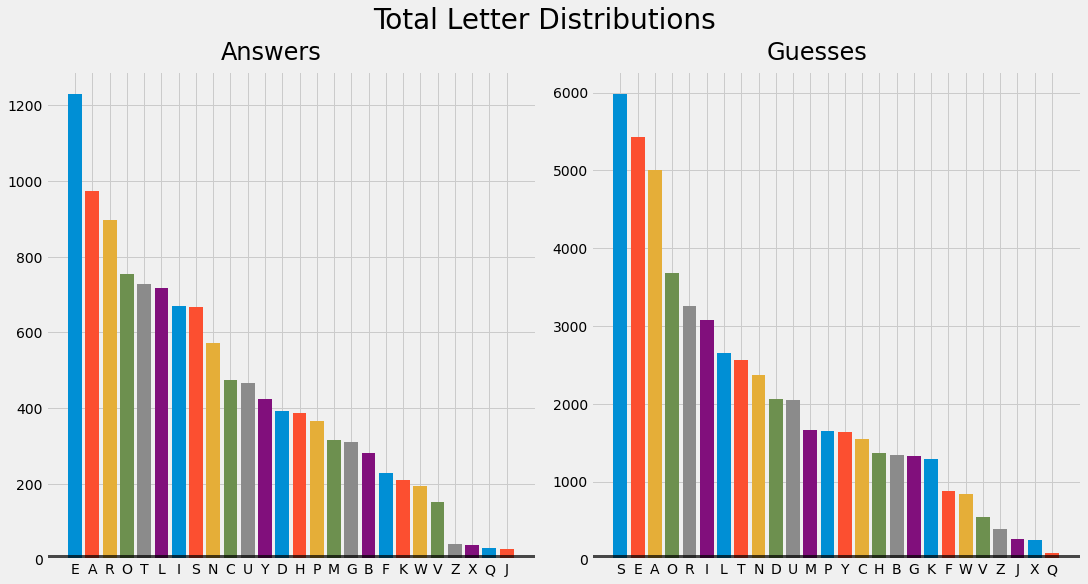

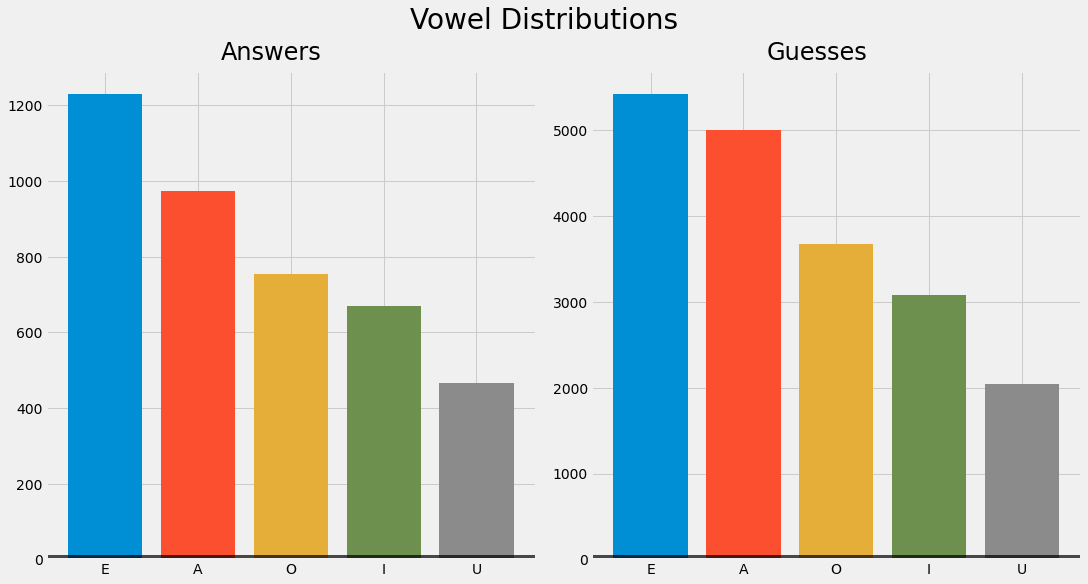

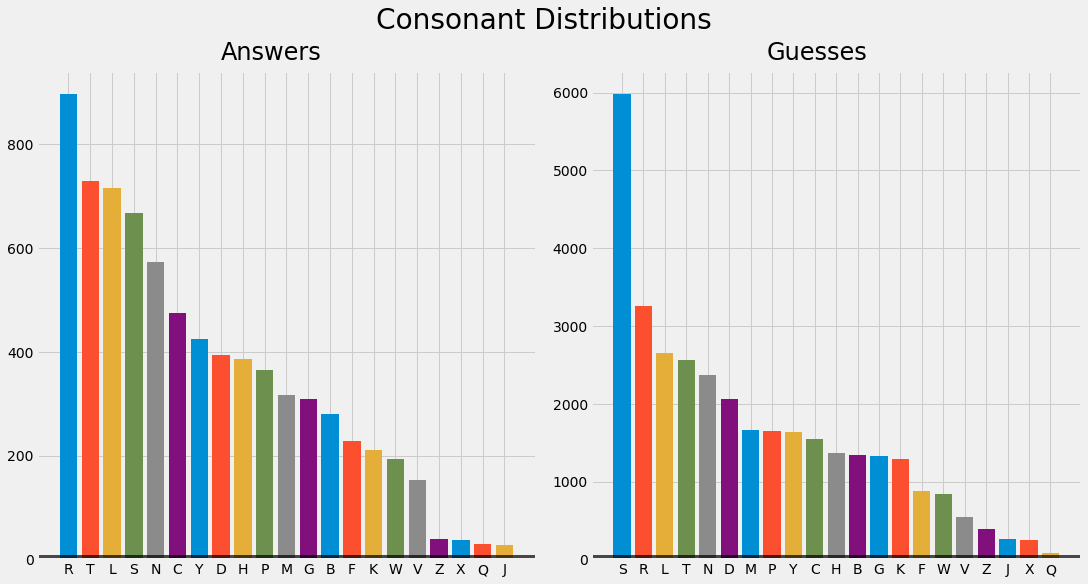

In [52]:
#gets number of times each letter shows up in words
answer_letter_counts = get_counts(answers)
guess_letter_counts = get_counts(guesses)

#get vowels-only and consonants-only
vowels_only_ans = filter_letters(answer_letter_counts, 1)
conson_only_ans = filter_letters(answer_letter_counts)
vowels_only_gue = filter_letters(guess_letter_counts, 1)
conson_only_gue = filter_letters(guess_letter_counts)

#gets number of times each letter shows up in given position
letter_pos_ans_counts, letter_pos_gue_counts = get_letter_pos_counts()

#plot letter distributions
plot_letter_dist_both(answer_letter_counts, guess_letter_counts)

#plot vowel distributions
plot_letter_dist_both(vowels_only_ans, vowels_only_gue, 'Vowel')

#plot consonant distributions
plot_letter_dist_both(conson_only_ans, conson_only_gue, 'Consonant')

## Observations So Far

We can see a few things from the above plot:

* **5 MOST FREQUENT LETTERS**:
    * Answers: E, A, R, O, T
    * Guesses: S, E, A, O, R
    
* **5 LEAST FREQUENT LETTERS**:
    * Answers: V, Z, X, Q, J
    * Guesses: V, Z, X, Q, J
    
* **5 MOST FREQUENT CONSONANTS**
    * Answers: R, T, L, S, N
    * Guesses: S, R, L, T, N
    
Interesting points of data:
* **'S'** is the most common letter in the guess word list, but it's ranked at the **8<sup>th</sup>** most common in the answer list (**4<sup>th</sup>** if you just look at consonants).
* The vowels for both word lists have roughly the same distribution proportions.
* Any [Wheel of Fortune](https://www.wheeloffortune.com/) fans might recognize the most frequent consonants as being the same given to the contestants during the bonus round. Though it doesn't always mean you [should pick them](https://medium.com/@edweng/ohgb-beating-the-wheel-of-fortune-bonus-round-ef9f47847124#:~:text=In%201988%2C%20Wheel%20of%20Fortune,with%20the%20most%20common%20letters%3F).

## Letter Distributions for Each Position

Now that we have explored a bit about overall letter frequency and distribution, let's take a closer look at how the letter position affects the distributions.

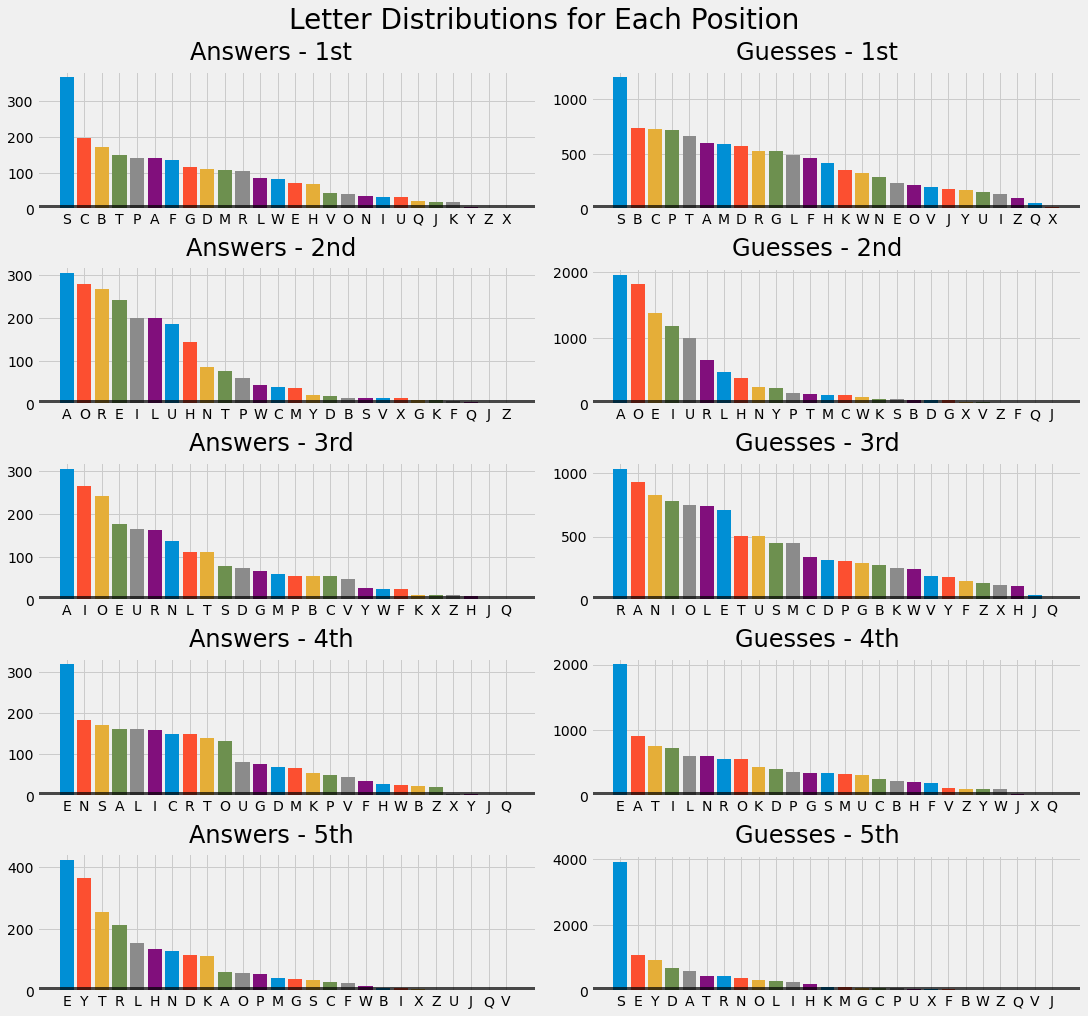

In [8]:
plot_letter_pos_dist(letter_pos_ans_counts, letter_pos_gue_counts)

# Observations

* **5 MOST FREQUENT FIRST LETTERS**:
    * Answers: S, C, B, T, P
    * Guesses: S, B, C, P, T
    
* **5 MOST FREQUENT LAST LETTERS**:
    * Answers: E, Y, T, R, L
    * Guesses: S, E, Y, D, A
    
Interesting points of data:

* For both lists, **'S'** is the most common first letter by a pretty large margin, almost double that of the next most common letter.
* For our guess word list, **'S'** is the most common first *AND* last letter, however for our answer word list, **'S'** ranks as the **15<sup>th</sup>** most common last letter!
* **'S'** is *by far* the most common last letter in our guess list - roughly 4x as likely to appear than the next most common last letter, **'E'**.

In [9]:
#create df of probabilities for each letter in each position
letters = pd.DataFrame(columns = ['1st', '2nd', '3rd', '4th', '5th'],
                       index=sorted(guess_letter_counts.keys()))

for i in range(26):
    probs = letter_prob_guesses(ALPHABET[i])
    for j in range(5):
        letters.iloc[i,j] = probs[j]

letters = letters.astype('float')
letters

,1st,2nd,3rd,4th,5th
A,0.056026,0.183869,0.087328,0.085636,0.057906
B,0.069092,0.006110,0.026133,0.020493,0.004512
C,0.067870,0.012784,0.031585,0.024065,0.009024
D,0.053582,0.006016,0.029611,0.037789,0.066178
E,0.021715,0.130194,0.066272,0.188475,0.103121
F,0.043241,0.001504,0.014382,0.018613,0.005264
G,0.049069,0.006016,0.027731,0.032525,0.009588
H,0.039387,0.037601,0.010434,0.019459,0.021621
I,0.012314,0.110829,0.073416,0.067870,0.025287
J,0.017108,0.000846,0.004042,0.002538,0.000282


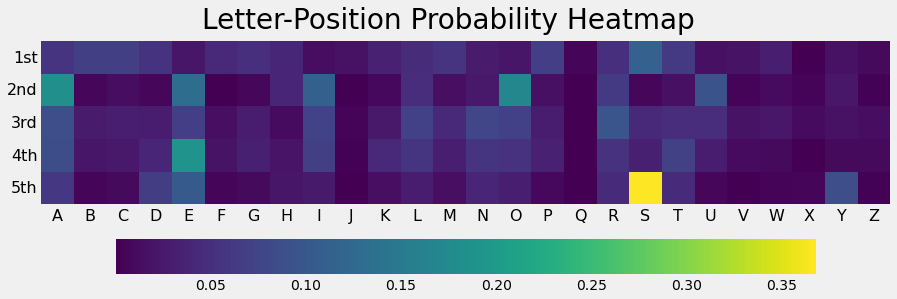

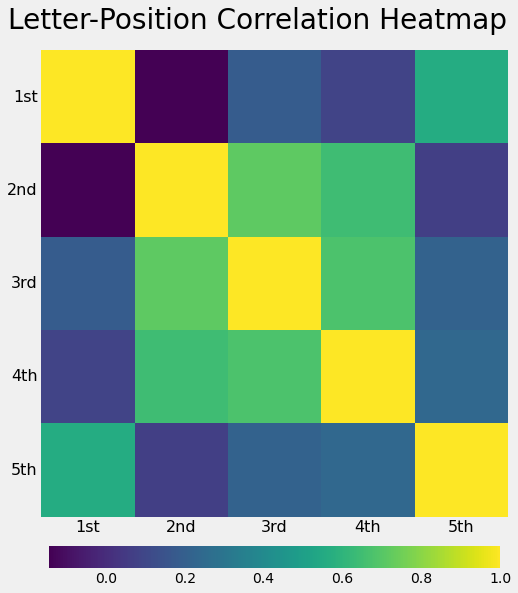

In [10]:
def plot_heatmap(data, horizontal=False):
    if horizontal:
        data = data.T
        orientation = 'horizontal'
        shrink = 0.9
        pad = 0.15
        fig_h = 4
        title = 'Letter-Position Probability Heatmap'
        y = 1
    else:
        orientation = 'horizontal'
        shrink = 0.45
        pad = 0.05
        fig_h = 10
        title = 'Letter-Position Correlation Heatmap'
        y = 0.94
        
    # if data.shape[0] == data.shape[1]:
    #     mask = np.zeros_like(letter_matrix, dtype=bool)
    #     mask[np.triu_indices_from(mask)] = True
    # else:
    mask = False
        
    #figure details
    fig = plt.figure(figsize=(16,fig_h))
    fig.tight_layout()
    fig.suptitle(title, y = y, fontsize=28, va = 'top')
    
    #plot details
    ax = sns.heatmap(data, square=True, mask=mask, cmap='viridis', cbar_kws={'shrink': shrink, 'orientation': orientation, 'pad': pad})
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 16)
plt.show()

plot_heatmap(letters, 1)
plot_heatmap(letters.corr())

# Helper Functions

In [11]:
#return list of guess words that have given letter in given position
def choices_inc(letter, pos, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if word[pos-1] == letter:
            choices.append(word)            
    return choices

#return list of guess words that contain letter NOT in given position
def choices_exc(letter, pos=0, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
    
    for word in word_bank:            
        if word[pos-1] != letter and letter in word:
            choices.append(word)   
    return choices

#return list of guess words that do NOT contain letter at all
def choices_abs_exc (letter, words=guesses):
    choices = []
    if words or len(words) == 0:
        word_bank = words
        
    for word in word_bank:
        if letter not in word:
            choices.append(word)    
    return choices

#calculates probability of given word and results
def get_probability(word, colors):
    word = word.upper()
    
    #list to contain lists of remaining possible matches
    pool = []
    
    #loop over each letter / color pair and compute remaining matches
    for i in range(5):
        #letter 1
        if i == 0:            
            if colors[i] == 'g': #green
                rem_set = choices_inc(word[i], i+1)
            elif colors[i] == 'r': #gray
                rem_set = choices_abs_exc(word[i])
            else: #yellow
                rem_set = choices_exc(word[i], i+1)
        
        #letters 2-5
        else:            
            if colors[i] == 'g':
                rem_set = choices_inc(word[i], i+1, pool[-1])
            elif colors[i] == 'r':
                rem_set = choices_abs_exc(word[i], pool[-1])
            else:
                rem_set = choices_exc(word[i], i+1, pool[-1])
        
        #adds remaining possible matches to pool
        if rem_set or len(rem_set) == 0:            
            pool.append(rem_set)

        # print(f'{word[i].upper()}, {colors[i]}, {len(rem_set)} matches left')
        
    num_matches = len(pool[-1])
    probability = num_matches / NUM_GUESSES
    
    #don't return an empty list
    if pool[-1] == []:
        pool[-1] = [0]        
    return probability, pool[-1]

#calculate information gain
def get_information(prob):
    if prob == 0:
        return 0.00
    return math.log2(1/prob)

#calculate entrooy of given probabilities
def get_entropy(data):    
    distributions = pd.Series(data)
    axis = len(distributions.shape) - 1
    return entropy(distributions, base=2.0, axis=axis)

#if PATTERN_MATRIX_FILE doesn't exist, create it - takes 45+ minutes!
def get_pattern_matrix(words):
    if not os.path.exists(PATTERN_MATRIX_FILE):
        all_p = {}
        for word in tqdm(words):
            all_p[word] = [get_probability(word, combo)[0] for combo in COMBINATIONS]

        #create dataframe of all probabilities
        pattern_matrix = pd.DataFrame.from_dict(all_p, orient='index', columns=COMBINATIONS).set_index('index')

        #create .csv file so we don't have to re-compute every time
        pattern_matrix.to_csv(f'pattern_matrix.csv', index=True)
        return pattern_matrix
    
    #else if PATTERN_MATRIX_FILE exists, read it in to df and return
    else:
        pattern_matrix = pd.read_csv('pattern_matrix.csv', index_col='index')
        return pattern_matrix

def plot_pattern_distr(word, dist):
    #create temp df
    df = pd.DataFrame(columns = ['Probability'])

    #assigns probability 
    df['Probability'] = dist.loc[word]

    #sorts highest -> lowest probability
    df.sort_values(by='Probability', ascending=False, inplace=True)
    
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'Probability Distribution - [{word}]', fontsize=22)
    fig.tight_layout()

    #plot
    sns.barplot(x=df.index, y=df['Probability'], palette='crest')
   
    #annotations
    xloc1 = 0
    yloc1 = df.iloc[xloc1,0]
    
    #higher entropy for most common
    ax.annotate(f'Max Entropy = {round(get_entropy(dist.loc[word]),2)}', fontsize=16,
                xy=(xloc1, yloc1), xytext=(xloc1+15, yloc1), 
                arrowprops=dict(arrowstyle='simple', facecolor='black'))
    
    #TODO - FIGURE OUT SECOND ANNOTATION - VERY INVOLVED!
#     xloc2 = 120
#     yloc2 = df.iloc[xloc2,0]
#     print(f'xloc: {xloc2}, yloc: {yloc2}')
#     print(f'df.iloc[xloc2, 0] = {df.iloc[xloc2, 0]}')
    
    
    
#     ind_calc = df[df['Probability'] == yloc2].index[0]
#     ind_p = get_probability(word, ind_calc)[0]
#     ind_i = get_information(ind_p)
    
    
#     #lower entropy for least common
#     ax.annotate(f'Entropy = {round(get_entropy(yloc2),2)}', fontsize=16,
#                 xy=(xloc2, yloc2), xytext=(xloc2-25, yloc2+0.01), 
#                 arrowprops=dict(arrowstyle='simple', facecolor='black'))

    #plot details    
    # ax.grid(visible=False)
    # ax.set_yscale('log')
    ax.set_xlim(-2,125,1)
    ax.set_xlabel(f'Patterns', fontsize=16)
    ax.set(ylabel=None)
    # ax.set_ylabel('Probability', fontsize=16)
    ax.tick_params(axis='x', labelbottom=False)
    ax.tick_params(axis='y', labelsize=12)
    ax.axhline(y = -0.00025, color = 'black', linewidth = 3, alpha = .7)
    plt.show()

#removes bad words from freq_map (NYT made these changes)
#couldn't figure out how to generate the freq_map file from wolframalpha
#so I used 3b1b's!, thus I have to edit it!
def get_word_frequencies(regenerate=False):
    bad_words = ['bitch', 'chink', 'coons', 'darky', 'dyked', 'dykes', 'dykey',
                 'faggy', 'fagot', 'gooks', 'homos', 'kikes', 'lesbo', 'pussy',
                 'sluts', 'spick', 'spics', 'spiks', 'whore', 'agora', 'fibre',
                 'lynch', 'pupal', 'slave', 'wench']
    if os.path.exists(WORD_FREQ_MAP_FILE) or regenerate:
        with open(WORD_FREQ_MAP_FILE) as fp:
            result = json.load(fp)
            for word in bad_words:
                del result[word]
        return result

#implementation of a sigmoid function
def sigmoid(x):  
    z = np.exp(-x)
    sig = 1 / (1 + z)
    return sig

#gets most commonly used words based on frequency
def get_freq_based_priority(n_common=3000, width_under_sigmoid=10):
    #get frequency map
    freq_map = get_word_frequencies()
    freqs_l = np.array([w for w in freq_map.keys()])
    freqs = np.array([freq_map[w] for w in freqs_l])

    #sorts list of frequencies - but returns indexes!
    arg_sort = freqs.argsort()

    #actually sorts list, converts to list() and capitalizes each word
    sorted_words = freqs_l[arg_sort].tolist()
    sorted_words = [w.upper() for w in sorted_words]

    #"bin" width for each word
    c = width_under_sigmoid * (-0.5 + n_common / NUM_GUESSES)
    xs = np.linspace(c - width_under_sigmoid / 2, c + width_under_sigmoid / 2, NUM_GUESSES)
    
    #dict to hold words
    priorities = dict()
    
    for word, x in zip(sorted_words, xs):
        priorities[word] = sigmoid(x)
    return priorities

#get "weights" of words - not every word is used equally!
def get_weights(words, priorities):
    frequencies = np.array([priorities[word] for word in words])
    total = frequencies.sum()
    if total == 0:
        return np.zeros(frequencies.shape)
    return frequencies / total

#returns new df containing adjusted probabilities with word weights
def get_pattern_distributions(priorities, dist):
    #get weights for each word
    weights = get_weights(guesses, priorities)

    #"blank" array same shape as `patterns`
    pattern_dist = np.zeros((NUM_GUESSES, 3**5))

    for i, prob in enumerate(weights):
        pattern_dist[i] += (dist.iloc[i,:] + prob)
        
    #makes df to be consistent with other objects
    pattern_dist = pd.DataFrame(pattern_dist, index=guesses, columns=COMBINATIONS)    
    return pattern_dist

In [12]:
#returns dataframe of ALL probabilities for EVERY combination of EVERY word - not weighted
patterns = get_pattern_matrix(guesses)

#display 5 random samples to show it works
patterns.sample(n=5)

,ggggg,ggggr,ggggy,gggrg,gggrr,gggry,gggyg,gggyr,gggyy,ggrgg,...,yyryy,yyygg,yyygr,yyygy,yyyrg,yyyrr,yyyry,yyyyg,yyyyr,yyyyy
index,,,,,,,,,,,,,,,,,,,,,
COGIE,0.000077,0.000000,0.0,0.000077,0.000077,0.000000,0.0,0.000000,0.0,0.000154,...,0.00000,0.000000,0.000077,0.0,0.000000,0.000386,0.000077,0.0,0.000077,0.000000
RIVET,0.000077,0.000386,0.0,0.000000,0.000154,0.000000,0.0,0.000000,0.0,0.000000,...,0.00139,0.000000,0.000000,0.0,0.000000,0.000772,0.000000,0.0,0.000232,0.000000
FYKES,0.000077,0.000077,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000154,...,0.00000,0.000000,0.000000,0.0,0.000077,0.000000,0.000000,0.0,0.000000,0.000000
SPOON,0.000077,0.000463,0.0,0.000000,0.000000,0.000000,0.0,0.000772,0.0,0.000000,...,0.00000,0.000077,0.001545,0.0,0.000000,0.000000,0.000000,0.0,0.006179,0.000695
PONCE,0.000077,0.000077,0.0,0.000000,0.000695,0.000154,0.0,0.000000,0.0,0.000000,...,0.00000,0.000000,0.000000,0.0,0.000077,0.001159,0.000232,0.0,0.000077,0.000000


Probability of guessing [SLATE] w/ [grryg] pattern = 0.0015
Information Gained in Bits = 9.41
Max Entropy - [SLATE] = 5.872430217496487


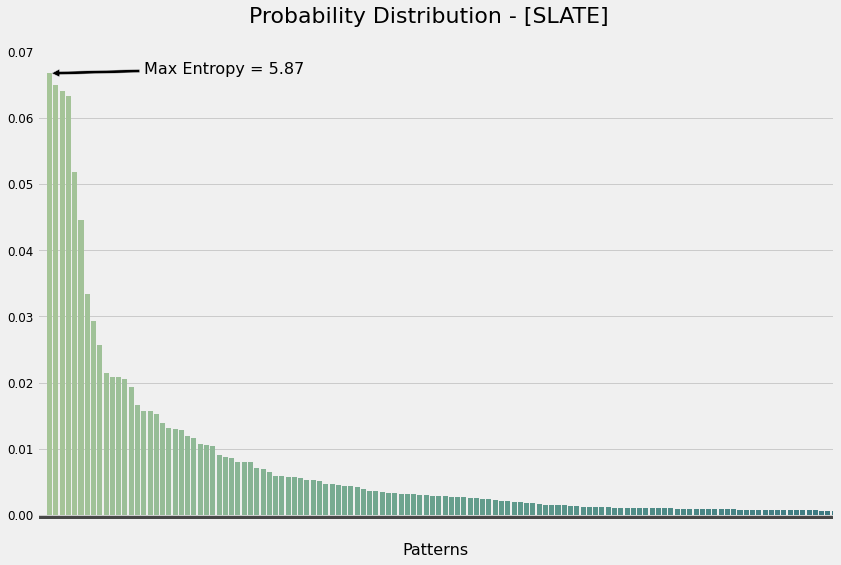

In [13]:
#testing functionality
find_word = 'SLATE'
find_patt = 'grryg'

#finds probability of given word with given pattern
p = patterns.loc[find_word, find_patt]
print(f'Probability of guessing [{find_word}] w/ [{find_patt}] pattern = {round(p,4)}')

#calculates information gain in bits
i = get_information(p)
print(f"Information Gained in Bits = {round(i,2)}")

# #print # of matches
# print(f'{len(matches)} possible matches')

#calculate entropy
print(f'Max Entropy - [{find_word}] = {get_entropy(patterns.loc[find_word])}')

#plot probability distribution
plot_pattern_distr(find_word, patterns)

In [14]:
#gets ordered dictionary of word frequency (least used -> most used)
priorities = get_freq_based_priority()

#gets distributions of patterns using newly adjusted probabilities
weighted_patterns = get_pattern_distributions(priorities, patterns)

#display 5 random samples to show it works
weighted_patterns.sample(n=5)

NameError: name 'json' is not defined

In [ ]:
plot_pattern_distr(find_word, weighted_patterns)

In [ ]:
from heapq import nlargest

largest = nlargest(50, priorities, key = priorities.get)
top_50 = ''
for key in largest:
    top_50 += key + ' '
    # print(f'{key}: {priorities[key]}')
    # print(key)
top_50 = top_50.rstrip()
top_50

In [ ]:
def most_common_letter(data, keys_only=False):
    sorted_dict = {}
    if keys_only:
        return sorted(data, key = data.get, reverse = True)
    else:
        sorted_tuples = sorted(data.items(), key = lambda x:x[1], reverse = True)
        sorted_dict = {k: v for k, v in sorted_tuples}
        return sorted_dict

common_dict = {}    
keys = ['1st', '2nd', '3rd', '4th', '5th']
for i, key in enumerate(keys):
    common_dict[key] = most_common_letter(letter_pos_ans_counts[i])
    
common = pd.DataFrame(common_dict, columns=keys)
common_f = common.apply(lambda x: x/NUM_ANSWERS)

In [ ]:
def plot_fancy_heatmap(data1, data2, data3):
    data1 = pd.DataFrame({'1st': data1['1st']},
                      index=data1.index)
    
    if isinstance(data2, pd.DataFrame):
        data2 = data2.iloc[:, np.arange(26)].astype('float64')
    else:
        data2 = data2.loc[:,['2nd', '3rd', '4th', '5th']]
        
    data1_l = pd.DataFrame()
    temp = list(data1.index)
    data1_l[0] = temp
    
    # plot it
    fig = plt.figure(figsize=(25, 12))
    fig.suptitle('Most Common First & Second Letter Combinations', fontsize=28, va = 'top', ha = 'center')
    
    ax0 = plt.subplot2grid((1, 3), (0, 0))
    ax0 = sns.heatmap(data1, annot=data1_l, square=True, fmt='', cmap='YlOrBr', xticklabels=False, yticklabels=False, vmin=0.0, vmax=0.2,
                      cbar_kws={'shrink': 1, 'location': 'left', 'pad':0.03, 'anchor':(10.3,0.0)})
    ax0.set_anchor('E')
    
    ax1 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
    ax1 = sns.heatmap(data2, annot=data3, square=True, fmt = '', cmap='Blues', xticklabels=False, yticklabels=False, vmin=0.0, vmax=0.25,
                      cbar=False, cbar_kws={'shrink': 0.65, 'orientation':'horizontal', 'location':'bottom', 'pad':0.01, 'anchor':(0.0, -1.5)})
    ax1.set_anchor('W')
    plt.tight_layout()
    plt.show()
    
# plot_fancy_heatmap(common_f)
# plot_fancy_heatmap(common_f, common_sv, common_sl)

In [ ]:
letter_pairs_counts = {}
for word in guesses:
    if word[:2] in letter_pairs_counts:
        letter_pairs_counts[word[:2]] += 1
    else:
        letter_pairs_counts[word[:2]] = 1

common_pairs = most_common_letter(letter_pairs_counts)

In [ ]:
def find_common():
    most_common_1st = {}
    
    for letter in ALPHABET:
        #get word list that starts with `letter`
        letter_words = [x for x in answers if x[0]==letter]
        most_common_2nd = {}
        
        #initialize every count to 0
        for l in ALPHABET:
            most_common_2nd[letter+l] = 0
        
        #frequency table for 2nd letter, given 1st letter
        for word in letter_words:
            if letter+word[1] in most_common_2nd:
                most_common_2nd[letter+word[1]] += 1
            else:
                most_common_2nd[letter+word[1]] = 1
    
        #sorts inner dictionary - most common 2nd letter
        sorted_tuples = sorted(most_common_2nd.items(), key = lambda x:x[1], reverse = True)
        sorted_dict = {k: v for k, v in sorted_tuples}
        
        #for each letter, assign dictionary of most common 2nd letters
        most_common_1st[letter] = sorted_dict
    return most_common_1st

#get most common 2nd letters, given `letter`
def get_2nd(data, letter):
    #gets the second letter from our dictionary keys
    tot = sum(data[letter].values())
    if tot == 0:
        tot = 1
    sec_letter = [x[0][1] for x in data[letter].items()]
    sec_value = [float(x[1]/tot) for x in data[letter].items()]
    return sec_letter, sec_value

def most_common_given_first(words=letter_pos_ans_counts):
    #finds most common first letter and uses it as index
    ind = list(most_common_letter(words[0]).keys())
    df1 = pd.DataFrame(index=ind, columns=np.arange(26))
    df2 = pd.DataFrame(index=ind, columns=np.arange(26))

    #calculates most common 2nd letter, and assigns to our df
    for i in range(26):
        #there's got to be a better way to do this?
        df1.iloc[i] = get_2nd(find_common(), df1.index[i])[0] #label
        df2.iloc[i] = get_2nd(find_common(), df2.index[i])[1] #value
        
    return df1, df2

In [ ]:
common_sl, common_sv = most_common_given_first()

plot_fancy_heatmap(common_f, common_sv, common_sl)